# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'
##### <div style="text-align: right"> BY </div>
##### <div style="text-align: right"> Vinay Agrawal </div>

# *Problem statement*: 
In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

 

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.


The project is an extended application of Show, Attend and Tell: Neural Image Caption Generation with Visual Attention paper.

 

The dataset is taken from the Kaggle website and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.

### The major steps that you have to perform can be briefly summarised in the following four steps:

- *Data Understanding*: Here, you need to load the data and understand the representation.
- *Data Preprocessing*: In this step, you will process both images and captions to the desired format.
- *Train-Test Split*: Combine both images and captions to create the train and test dataset.
- *Model Building*: This is the stage where you will create your image captioning model by building Encoder, Attention and - -Decoder model.
- *Model Evaluation*: Evaluate the models using greedy search and BLEU score.

In [1]:
## Checking the GPU configuration

!nvidia-smi

Sun Jan  9 01:31:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#installing tensorflow gpu as gpu was not detecting
# !pip uninstall tensorflow -y
# !pip install tensorflow-gpu

In [3]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [4]:
#checking the tf version
import sys
print (sys.version)
# 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
import tensorflow as tf
print(tf.__version__)
# my output was => 1.13.1

3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
2.4.1


In [5]:
#checking the GPU is detected or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14556905557728035699
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15366068782209507519
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18138966183854107214
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2310032885187842839
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


**`Analysis Comments`**:
    
    Now GPU is detected 

In [8]:
pwd

'/mnt/disks/user/project/Eye for blind'

In [9]:
#install zip
# !sudo apt update
# !sudo apt install p7zip-full unzip zip -y

In [10]:
# For downloading the dataset
# Go to Kaggle.com -> My Account -> Create new API Token -> Upload kaggle.json in Jupyter Home/CNN/
!cp ./kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!mkdir -p dataset
!kaggle datasets download -d adityajn105/flickr8k
!mv flickr8k.zip dataset/

100%|█████████████████████████████████████▊| 1.03G/1.04G [00:38<00:00, 28.6MB/s]
100%|██████████████████████████████████████| 1.04G/1.04G [00:38<00:00, 29.0MB/s]


In [11]:
!ls -al dataset/

total 1090572
drwxrwxr-x 5 ubuntu ubuntu       4096 Jan  9 01:32 .
drwxrwxr-x 4 ubuntu ubuntu       4096 Jan  9 01:32 ..
drwxrwxr-x 2 ubuntu ubuntu       4096 Jan  9 01:19 .ipynb_checkpoints
drwx------ 2 ubuntu ubuntu     425984 Jan  2 16:46 Images
drwxr-xr-x 2 ubuntu ubuntu       4096 Jan  9 01:30 Train
-rw-rw-r-- 1 ubuntu ubuntu    3319294 Apr 27  2020 captions.txt
-rw-rw-r-- 1 ubuntu ubuntu 1112971163 Jan  9 01:32 flickr8k.zip


In [12]:
!pwd

/mnt/disks/user/project/Eye for blind


In [13]:
# #!unzip flickr8k.zip
# !7za x flickr8k.zip -y
# !rm flickr8k.zip

In [14]:
#!rm -rf Images/

In [16]:
#Import all the required libraries

from skimage import io
import glob
import seaborn as sns
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings('ignore')

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [17]:
#Import the dataset and read the image into a seperate variable

images=('dataset/Images')

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


Printing first five captions of caption txt file
 ['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n']
Below image file name is dataset/Images/3090600019_8808fe7a9d.jpg


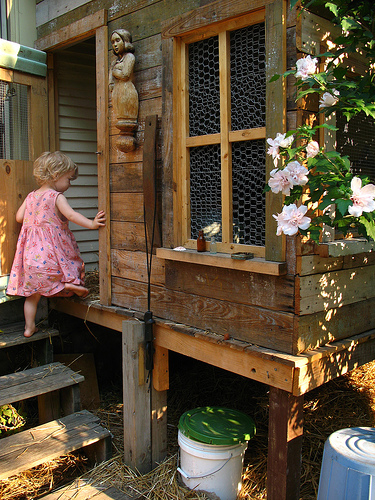

In [18]:
#Visualise both the images & text present in the dataset

with open('dataset/captions.txt') as f:
    lines = f.readlines()
print("Printing first five captions of caption txt file\n",lines[1:6])
print('Below image file name is',all_imgs[1])
Image.open('dataset/Images/1000268201_693b08cb0e.jpg')

In [19]:

def visualise_image(images, caption = None, cmap = None):
    f, axes = plt.subplots(1, len(images))
    f.set_figwidth(20)
    f = plt.figure(figsize=(7, 5))
    
    for ax, image in zip(axes, images):
        ax.imshow(io.imread(image), cmap)

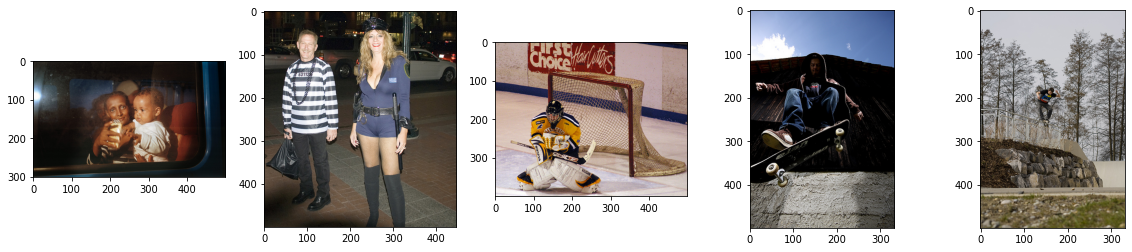

<Figure size 504x360 with 0 Axes>

In [20]:
visualise_image(all_imgs[:5])

In [21]:
#Import the dataset and read the text file into a seperate variable
text_file=("dataset/captions.txt")
def load_doc(filename):
    
    file=open(filename)
    text=file.read()
    file.close()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [22]:
img = 'dataset/Images/'

def get_imgsid_captions(text):
    ids=[]
    vals=[]
    ids_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        co_idx=line.index(",")
        im_id,im_cap=line[:co_idx],line[co_idx+1:]
        ids.append(im_id)
        vals.append(im_cap)
        ids_paths.append(img+im_id)
    return ids,vals,ids_paths

In [23]:
# all_img_id= [] #store all the image id here
# all_img_vector= [] #captions_df['image'] #store all the image path here
# annotations= [] # captions_df['caption'] #store all the captions here'
# pd.set_option('display.max_colwidth', None)
# with open(text_file, 'r') as fo:
#     next(fo) # to skip the heading 
#     for line in fo:
#         split_arr=line.split(',')
#         all_img_id.append(split_arr[0])
#         annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
#         all_img_vector.append(images+'/'+split_arr[0])
        

# df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
# df

In [24]:
#all_img_id= #store all the image id here
#all_img_vector= #store all the image path here
#annotations= #store all the captions here
pd.set_option('display.max_colwidth', None)
doc1=doc.splitlines()[1:] #This splits the string file before and after each line
all_img_id=[]
annotations=[]
all_img_vector=[]
for i in doc1:
    idx=i.index(",")         ###Setting the "," seperator as the index
    image_id=i[:idx]         ###This will store the values before the "," seperator in each line
    image_caption=i[idx+1:]  ###This will store the values after the "," seperator in each line
    all_img_id.append(image_id)   
    annotations.append(image_caption)
    all_img_vector.append(images+"/"+ image_id)
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,dataset/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,dataset/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,dataset/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...,...
40450,997722733_0cb5439472.jpg,dataset/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,dataset/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,dataset/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472.jpg,dataset/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


### Visualize the image and captions

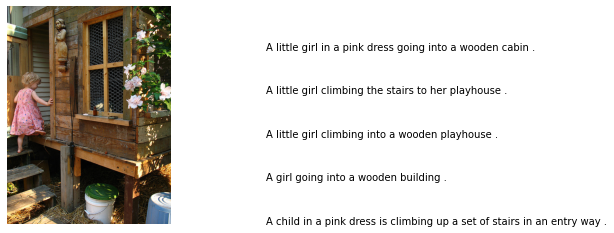

In [25]:
#Visualize caption and image
# image_paths = all_img_path
# all_captions = []
# img_name_vector = []
# for image_path in image_paths:
#     caption_list = image_path_to_caption[image_path]
#     all_captions.extend(caption_list)
#     img_name_vector.extend([image_path] * len(caption_list))

f, axes = plt.subplots(1, 2)
plt.axis('off')
f.set_figwidth(10)
axes[0].imshow(io.imread(all_img_vector[0]))
axes[0].axis('off')
axes[1].set_ylim(0,5)
for i in range(0,5):
    axes[1].text(0,i,annotations[i])
    
    
 

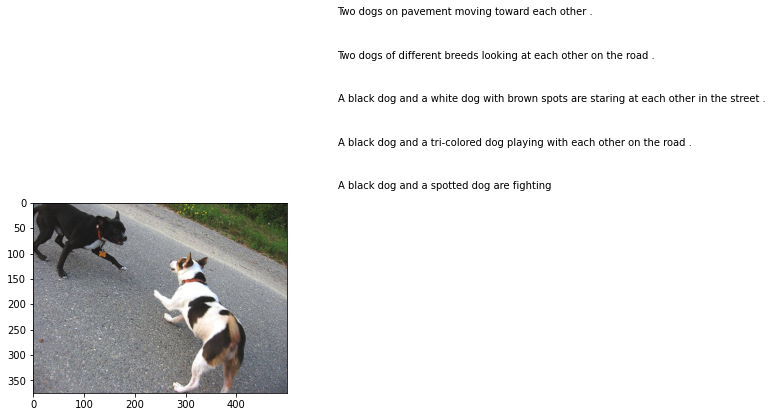

In [30]:
#Visualize caption and image
f, axes = plt.subplots(1, 2)
plt.axis('off')
f.set_figwidth(10)
axes[0].imshow(io.imread(all_img_vector[5]))
axes[0].axis('off')
axes[1].set_ylim(0,5)
for i in range(5,10):
    axes[1].text(0,i,annotations[i])   

In [150]:
# def caption_and_image_plotter(image_id,frame):
#     #get captions
#     caps=("\n"*2).join(frame[frame['ID']==image_id].Captions.to_list())
#     fig, ax = plt.subplots()
#     ax.set_axis_off()
#     idx=df.ID.to_list().index(image_id)
#     im=Image.open(df.Path.iloc[idx])
#     w,h=im.size[0],im.size[-1]
#     ax.imshow(im)
#     ax.text(w+50,h,caps,fontsize=20,color='green')
# caption_and_image_plotter(df.ID.iloc[8049],df)

In [151]:
# def run_caption_and_image_plotter_for_a_range(start,end,frame):
#     for i in range(start,end):
#         caption_and_image_plotter(frame.ID.drop_duplicates().iloc[i],frame)
# run_caption_and_image_plotter_for_a_range(0,5,df)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [32]:
#checking caption column
df["Captions"]

0           A child in a pink dress is climbing up a set of stairs in an entry way .
1                                              A girl going into a wooden building .
2                                   A little girl climbing into a wooden playhouse .
3                               A little girl climbing the stairs to her playhouse .
4                          A little girl in a pink dress going into a wooden cabin .
                                            ...                                     
40450                                       A man in a pink shirt climbs a rock face
40451                                       A man is rock climbing high in the air .
40452    A person in a red shirt climbing up a rock face covered in assist handles .
40453                                                A rock climber in a red shirt .
40454                             A rock climber practices on a rock climbing wall .
Name: Captions, Length: 40455, dtype: object

In [33]:
#Create a list which contains all the captions
annotations=df.Captions.apply(lambda x:"<start>"+" "+x+" "+"<end>")

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=all_img_vector#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [34]:
#printing first 5 rows
print(annotations[:5])

0    <start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>
1                                       <start> A girl going into a wooden building . <end>
2                            <start> A little girl climbing into a wooden playhouse . <end>
3                        <start> A little girl climbing the stairs to her playhouse . <end>
4                   <start> A little girl in a pink dress going into a wooden cabin . <end>
Name: Captions, dtype: object


**`Analysis Comments`**: 

This shows that we have succesfully added the start and the end tokens.

In [35]:
# def create_vocabulary(data):
#   vocab = []
#   for captions in data.Captions.values:
#     vocab.extend(captions.split())
#   print("Vocabulary Size : {}".format(len(set(vocab))))
#   return vocab

In [36]:
# #Create the vocabulary & the counter for the captions
# from collections import Counter

# vocabulary = create_vocabulary(df)#write your code here

# val_count=Counter(vocabulary)
# val_count

In [37]:
#Create the vocabulary & the counter for the captions
##To use counter we need to seperate each WORD seperately. Hence we would seperate each word 
#and put it in a list.
vocabulary=[]
for i in df["Captions"]:
    vocabulary=vocabulary+i.split(" ")

#vocabulary= #write your code here

val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

In [38]:
#Checking the type of val_count
type(val_count)

collections.Counter

In [39]:
#Visualise the top 30 occuring words in the captions

#write your code here
most_occur = val_count.most_common(30)

print(most_occur)

[('a', 40271), ('.', 34212), ('A', 21481), ('in', 18961), ('the', 15328), ('on', 10729), ('is', 9345), ('and', 8850), ('dog', 7982), ('with', 7760), ('man', 6828), ('of', 6712), ('Two', 3962), ('white', 3875), ('black', 3696), ('are', 3503), ('boy', 3442), ('woman', 3227), ('girl', 3217), (',', 3210), ('to', 3173), ('wearing', 3061), ('The', 2920), ('at', 2904), ('water', 2774), ('red', 2660), ('brown', 2475), ('people', 2442), ('young', 2431), ('."', 2365)]


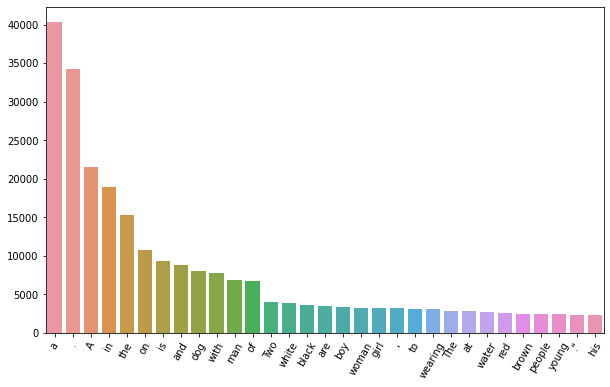

In [40]:
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
get_top_words_based_on_cnt(val_count,30)

In [41]:
# #Visualise the top 30 occuring words in the captions
# df1=pd.DataFrame.from_dict(val_count,orient="index")
# df1=df1.sort_values(by=[0],ascending=False)
# df1=df1.reset_index()
# df1.columns=["Words","Count"]
# df1=df1.head(30)

In [42]:
# plt.figure(figsize=(15,8))
# plt.title("Top 30 occuring words in the captions",fontsize=18)
# plt.bar(df1["Words"],height=df1["Count"])
# plt.xlabel("Words")
# plt.ylabel("Count")
# plt.xticks(df1["Words"],rotation=90,fontsize=12)
# plt.show()


In [43]:
#help(tf.keras.preprocessing.text.Tokenizer)

In [44]:
# #Creating start and end token after and before each caption
# annotations = df.Captions.apply(lambda x:"<start>"+" "+x+" "+"<end>") #add the <start> & <end> token to all those captions as well

# print(str(len(annotations)))

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [45]:
# create the tokenizer
#your code here
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=5000,oov_token="<unk>",
                                                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)

In [46]:
# Create word-to-index and index-to-word mappings.
train_seqs = tokenizer.texts_to_sequences(annotations)
#your code here
pad_token="<pad>"
tokenizer.word_index[pad_token] = 0
tokenizer.index_word[0] = pad_token

In [47]:
annotations[:10]

0                  <start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>
1                                                     <start> A girl going into a wooden building . <end>
2                                          <start> A little girl climbing into a wooden playhouse . <end>
3                                      <start> A little girl climbing the stairs to her playhouse . <end>
4                                 <start> A little girl in a pink dress going into a wooden cabin . <end>
5                                                <start> A black dog and a spotted dog are fighting <end>
6                   <start> A black dog and a tri-colored dog playing with each other on the road . <end>
7    <start> A black dog and a white dog with brown spots are staring at each other in the street . <end>
8                          <start> Two dogs of different breeds looking at each other on the road . <end>
9                                           <s

In [48]:
train_seqs[:10]

[[4, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 3],
 [4, 2, 20, 317, 65, 2, 197, 118, 3],
 [4, 2, 41, 20, 120, 65, 2, 197, 2436, 3],
 [4, 2, 41, 20, 120, 6, 395, 21, 61, 2436, 3],
 [4, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2980, 3],
 [4, 2, 16, 10, 9, 2, 843, 10, 18, 344, 3],
 [4, 2, 16, 10, 9, 2, 1575, 236, 10, 35, 11, 138, 83, 7, 6, 152, 3],
 [4, 2, 16, 10, 9, 2, 15, 10, 11, 28, 1001, 18, 641, 23, 138, 83, 5, 6, 73, 3],
 [4, 14, 32, 13, 741, 2652, 90, 23, 138, 83, 7, 6, 152, 3],
 [4, 14, 32, 7, 727, 805, 322, 138, 83, 3]]

In [49]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

<unk>
<pad>


In [50]:
tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: 'end',
 4: 'start',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog',
 11: 'with',
 12: 'man',
 13: 'of',
 14: 'two',
 15: 'white',
 16: 'black',
 17: 'boy',
 18: 'are',
 19: 'woman',
 20: 'girl',
 21: 'to',
 22: 'wearing',
 23: 'at',
 24: 'people',
 25: 'water',
 26: 'red',
 27: 'young',
 28: 'brown',
 29: 'an',
 30: 'his',
 31: 'blue',
 32: 'dogs',
 33: 'running',
 34: 'through',
 35: 'playing',
 36: 'while',
 37: 'shirt',
 38: 'down',
 39: 'standing',
 40: 'ball',
 41: 'little',
 42: 'grass',
 43: 'snow',
 44: 'child',
 45: 'person',
 46: 'jumping',
 47: 'over',
 48: 'three',
 49: 'front',
 50: 'sitting',
 51: 'holding',
 52: 'up',
 53: 'field',
 54: 'small',
 55: 'by',
 56: 'large',
 57: 'green',
 58: 'one',
 59: 'group',
 60: 'yellow',
 61: 'her',
 62: 'walking',
 63: 'children',
 64: 'men',
 65: 'into',
 66: 'air',
 67: 'beach',
 68: 'near',
 69: 'mouth',
 70: 'jumps',
 71: 'another',
 72: 'for',
 73: 'street',
 74: 'runs',
 75: 'its',
 76:

In [51]:
#function to get the word to index
def print_word_2_index(word):
    print("Word = {}, index = {}".format(word, tokenizer.word_index[word]))
print( "Word 2 index mapping")
print_word_2_index("start")
print_word_2_index("<pad>")

Word 2 index mapping
Word = start, index = 4
Word = <pad>, index = 0


In [52]:
# Create index-to-word mappings.
def print_index_2_word(index):
    print("Index = {}, Word = {}".format(index, tokenizer.index_word[index]))

          
print( "Index 2 word mapping")
print_index_2_word(4)
print_index_2_word(0)

Index 2 word mapping
Index = 4, Word = start
Index = 0, Word = <pad>


In [53]:
word_counts=tokenizer.word_counts
word_counts

OrderedDict([('start', 40464),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('end', 40507),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('colored',

In [54]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
df_word_count=pd.DataFrame.from_dict(word_counts,orient="index")
df_word_count=df_word_count.sort_values(by=[0],ascending=False)
df_word_count=df_word_count.reset_index()
df_word_count.columns=["Words","Count"]
df_word_count=df_word_count.head(30)

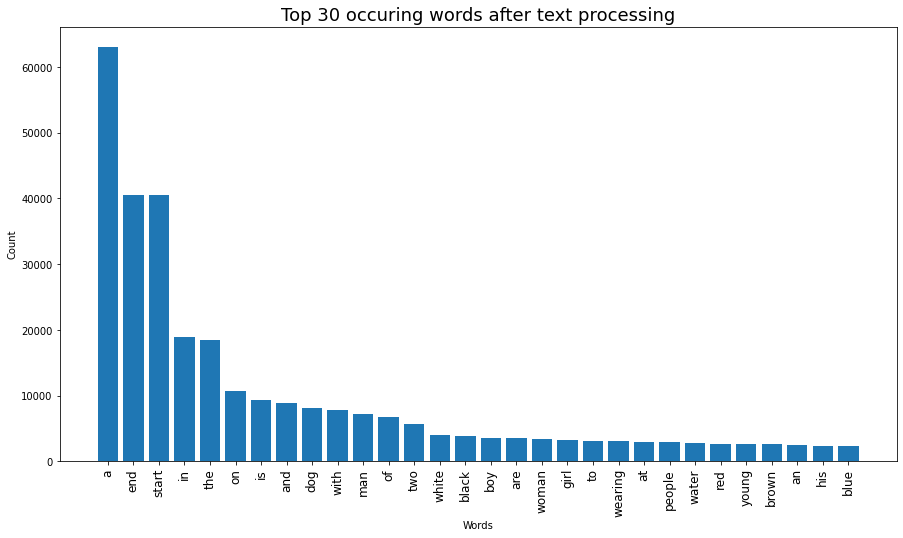

In [55]:
plt.figure(figsize=(15,8))
plt.title("Top 30 occuring words after text processing",fontsize=18)
plt.bar(df_word_count["Words"],height=df_word_count["Count"])
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(df_word_count["Words"],rotation=90,fontsize=12)
plt.show()

In [56]:
#Creating the tokenized vector
text_sequence = tokenizer.texts_to_sequences(annotations)

In [57]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
max_length= max(len(t) for t in text_sequence)

#Here post padding would be apprpriate which means adding zeroes at the end of the sequence
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(text_sequence, padding='post',maxlen=max_length)


print(cap_vector.shape)

(40455, 39)


In [58]:
max_length

39

In [59]:
cap_vector

array([[ 4,  2, 44, ...,  0,  0,  0],
       [ 4,  2, 20, ...,  0,  0,  0],
       [ 4,  2, 41, ...,  0,  0,  0],
       ...,
       [ 4,  2, 45, ...,  0,  0,  0],
       [ 4,  2, 86, ...,  0,  0,  0],
       [ 4,  2, 86, ...,  0,  0,  0]], dtype=int32)

**`Analysis Comments`** : 

Padding zero at last using padding='post'. We know that start token acts as prompter and it expect some word after tat. Zero indicates no word and have no value at beginning.So,in order to not disturb the existing sequence structure we pad at end. This padding will cause problem while creating embedding vector.So we will be applying mask then.

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [60]:
#write your code here to create the dataset consisting of image paths

## Since the image path will have duplicates we will use it as a set to get rid of duplicates
## Since tf.data.Dataset.from_tensor_slices doesn't accept set, we use sorted to convert it into list.
new_path_file=sorted(set(all_img_vector))
dataset=tf.data.Dataset.from_tensor_slices(new_path_file)
dataset

<TensorSliceDataset shapes: (), types: tf.string>

**`Analysis Comments`**:

This dataset may look empty seeing the shape but when we iterate, we see that it has values.

In [61]:
##Iterating through the dataset
for i in dataset:
    print(i)

tf.Tensor(b'dataset/Images/1000268201_693b08cb0e.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1001773457_577c3a7d70.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1002674143_1b742ab4b8.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1003163366_44323f5815.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1007129816_e794419615.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1007320043_627395c3d8.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1009434119_febe49276a.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1012212859_01547e3f17.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1015118661_980735411b.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1015584366_dfcec3c85a.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/101654506_8eb26cfb60.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/101669240_b2d3e7f17b.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/Images/1016887272_03199f49c4.jpg',

In [62]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,(299,299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    
    return  image, image_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)


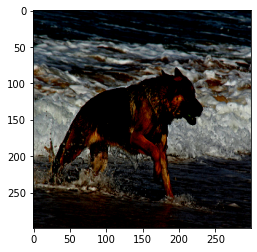

In [63]:
#checking the load funtion
img1,img1_path = load_image("dataset/Images/225909073_25c3c33a29.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

In [64]:
tf.data.experimental.AUTOTUNE

-1

In [65]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

dataset=dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
dataset


<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [66]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output ##Here -1 is used because we need the last layer output

image_features_extract_model = keras.Model(new_input,hidden_layer)

In [67]:
# write your code to extract features from each image in the dataset
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [68]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
features_dict={}
for image,path in tqdm(dataset):
    features = image_features_extract_model(image)
    features = tf.reshape(features,(features.shape[0], -1, features.shape[3]))
    for feat, p in zip(features, path):
        feat_path = p.numpy().decode("utf-8") ##This decoding is done because the values are not in ASCII
        features_dict[feat_path] =  feat.numpy() ##This will convert the tensor instance to numpy

100%|██████████| 253/253 [01:50<00:00,  2.28it/s]


In [69]:
features.shape

TensorShape([27, 64, 2048])

**The dictionary has to be saved while reshaping the features otherwise there will be a key error.**

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [70]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,
                                                              train_size=0.8,random_state=42 )

In [71]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [72]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
        
def map_func(image_path,caption):
    img_tensor = features_dict[image_path.decode('utf-8')] #Since the source text is in UTF-8 format
    return img_tensor,caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [73]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(img_path1,captions):
    dataset1=tf.data.Dataset.from_tensor_slices((img_path1,captions))
    dataset1=dataset1.shuffle(1000,reshuffle_each_iteration=True)
    dataset1=dataset1.map(lambda x,y:tf.numpy_function(map_func,[x,y],[tf.float32,tf.int32])).batch(32)
    dataset1=dataset1.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset1

In [74]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [75]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

**Batch size of 64 is giving me memory exhausted error. Hence would go with 32.**

### Set the parameters

In [76]:
embedding_dim = 256 
units = 512
BATCH_SIZE=32
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Build the Encoder, Attention model & Decoder

#### Encoder

In [77]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features =  self.dense(features)
        features = tf.nn.relu(features)
        
        return features

In [78]:
encoder=Encoder(embedding_dim)

#### Attention model

Attention models require continuous reinforcement or backpopagation training to be effective. Attention model takes input from Encoder(feature Vector) and Decoder(Hidden State) nd returns Context Vector with words.

In [79]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden,1)
        score = self.V(tf.nn.tanh(self.W1(features) +self.W2(hidden_with_time_axis)))
        attention_weights =  tf.nn.softmax(score, axis=1)
        context_vector =  attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1) #To squeeze the output to a smaller
                                                               #dimension
        
        return context_vector, attention_weights

#### Decoder

In [80]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed =  self.embed(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [81]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [82]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['start']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

### Set the optimizer & loss object

In [83]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [84]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    

    return tf.reduce_mean(loss_)

### Create your checkpoint path

In [85]:
checkpoint_path = ("dataset/Train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [86]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

### Create your training & testing step functions

In [87]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [88]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))        
    return loss, avg_loss

### Create your loss function for the test dataset

In [89]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [90]:
#Importing the required packages
import time
loss_plot=[]
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/20 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

  5%|▌         | 1/20 [03:38<1:09:13, 218.61s/it]

For epoch: 2, the train loss is 0.937, & test loss is 0.898
Time taken for 1 epoch 116.98340797424316 sec

Test loss has been reduced from 1.011 to 0.898


 10%|█         | 2/20 [05:36<47:44, 159.16s/it]  

For epoch: 3, the train loss is 0.853, & test loss is 0.828
Time taken for 1 epoch 116.87967133522034 sec

Test loss has been reduced from 0.898 to 0.828


 20%|██        | 4/20 [09:30<34:54, 130.93s/it]

For epoch: 4, the train loss is 0.793, & test loss is 0.772
Time taken for 1 epoch 116.75928020477295 sec

Test loss has been reduced from 0.828 to 0.772


 25%|██▌       | 5/20 [11:27<31:28, 125.87s/it]

For epoch: 5, the train loss is 0.742, & test loss is 0.725
Time taken for 1 epoch 116.80885076522827 sec

Test loss has been reduced from 0.772 to 0.725


 30%|███       | 6/20 [13:24<28:39, 122.82s/it]

For epoch: 6, the train loss is 0.698, & test loss is 0.682
Time taken for 1 epoch 116.76333737373352 sec

Test loss has been reduced from 0.725 to 0.682


 35%|███▌      | 7/20 [15:20<26:10, 120.81s/it]

For epoch: 7, the train loss is 0.659, & test loss is 0.645
Time taken for 1 epoch 116.5480215549469 sec

Test loss has been reduced from 0.682 to 0.645


 40%|████      | 8/20 [17:18<23:56, 119.70s/it]

For epoch: 8, the train loss is 0.622, & test loss is 0.609
Time taken for 1 epoch 117.22624444961548 sec

Test loss has been reduced from 0.645 to 0.609


 45%|████▌     | 9/20 [19:15<21:46, 118.81s/it]

For epoch: 9, the train loss is 0.590, & test loss is 0.577
Time taken for 1 epoch 116.71783804893494 sec

Test loss has been reduced from 0.609 to 0.577


 50%|█████     | 10/20 [21:11<19:41, 118.17s/it]

For epoch: 10, the train loss is 0.560, & test loss is 0.549
Time taken for 1 epoch 116.63312864303589 sec

Test loss has been reduced from 0.577 to 0.549


 55%|█████▌    | 11/20 [23:08<17:39, 117.74s/it]

For epoch: 11, the train loss is 0.532, & test loss is 0.523
Time taken for 1 epoch 116.63026595115662 sec

Test loss has been reduced from 0.549 to 0.523


 60%|██████    | 12/20 [25:05<15:39, 117.46s/it]

For epoch: 12, the train loss is 0.507, & test loss is 0.498
Time taken for 1 epoch 116.72115540504456 sec

Test loss has been reduced from 0.523 to 0.498


 65%|██████▌   | 13/20 [27:02<13:41, 117.30s/it]

For epoch: 13, the train loss is 0.484, & test loss is 0.475
Time taken for 1 epoch 116.7997362613678 sec

Test loss has been reduced from 0.498 to 0.475


 70%|███████   | 14/20 [28:59<11:43, 117.17s/it]

For epoch: 14, the train loss is 0.464, & test loss is 0.456
Time taken for 1 epoch 116.73991107940674 sec

Test loss has been reduced from 0.475 to 0.456


 75%|███████▌  | 15/20 [30:56<09:45, 117.09s/it]

For epoch: 15, the train loss is 0.445, & test loss is 0.438
Time taken for 1 epoch 116.80035972595215 sec

Test loss has been reduced from 0.456 to 0.438


 80%|████████  | 16/20 [32:53<07:48, 117.13s/it]

For epoch: 16, the train loss is 0.428, & test loss is 0.421
Time taken for 1 epoch 117.10315799713135 sec

Test loss has been reduced from 0.438 to 0.421


 85%|████████▌ | 17/20 [34:49<05:50, 116.98s/it]

For epoch: 17, the train loss is 0.412, & test loss is 0.407
Time taken for 1 epoch 116.51929926872253 sec

Test loss has been reduced from 0.421 to 0.407


 90%|█████████ | 18/20 [36:46<03:53, 116.88s/it]

For epoch: 18, the train loss is 0.398, & test loss is 0.391
Time taken for 1 epoch 116.53064823150635 sec

Test loss has been reduced from 0.407 to 0.391


 95%|█████████▌| 19/20 [38:43<01:56, 116.85s/it]

For epoch: 19, the train loss is 0.384, & test loss is 0.379
Time taken for 1 epoch 116.64123749732971 sec

Test loss has been reduced from 0.391 to 0.379


100%|██████████| 20/20 [40:40<00:00, 122.00s/it]

For epoch: 20, the train loss is 0.372, & test loss is 0.366
Time taken for 1 epoch 116.5768690109253 sec

Test loss has been reduced from 0.379 to 0.366


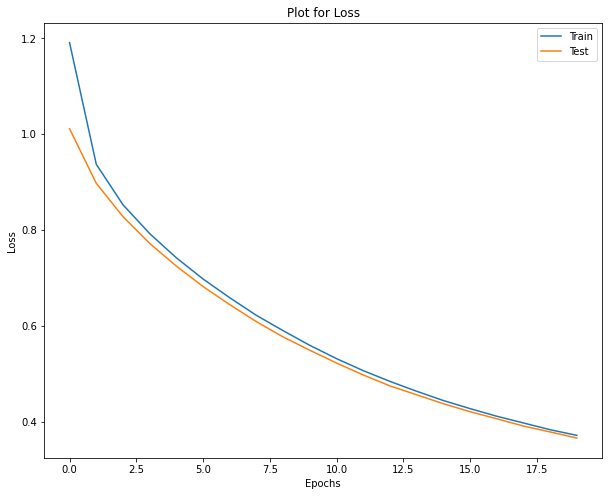

In [91]:
plt.figure(figsize=[10,8])
plt.title('Plot for Loss')
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(["Train","Test"],loc="best")
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

**`Analysis Comments`**

- Here the blue line represents the training loss and the orange line represents the validation loss.
    
- On the X-axis, we have the number of epochs and on the Y-axis we have the loss values. Now, while making the predictions, the weights and biases stored at the very last epoch will be used. So the model will train completely till the specified number of epochs, which is 15 in this case. And the parameters learned during the last epoch will be used in order to make the predictions.

- Loss is reduced to 0.366

When i increased the epochs to 20 from 15 then model started performing well and loss reduced from 0.441 to 0.366

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

1) It is an algorithm paradigm that builds the solution piece by piece.

2) For each step, it offers the piece offering the most immediate benefit.

3) It fits perfecty for those algorithms where local optimal solutions lead to global solution.

The prediction of the words by the model is done by finding out the probabilities of that word in the vocabulary. We are using the greedy search method. It calculates the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

In [92]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =tf.random.categorical(predictions, 1)[0][0].numpy() #the format needs to be in numpy
        result.append(tokenizer.index_word[predicted_id])


        if tokenizer.index_word[predicted_id] == 'end':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

Beam Search explores the most promising node (word).

In [93]:
def beam_evaluate(image, beam_index = 3):
    max_length=39
    start = [tokenizer.word_index['start']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [94]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [95]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [96]:
features_shape = feat.shape[1]
attention_features_shape = feat.shape[0]

BELU score: 80.33211350634542
Real Caption: start numerous african americans wearing various of clothing end
Prediction Caption: numerous african americans wearing various <unk> of clothing


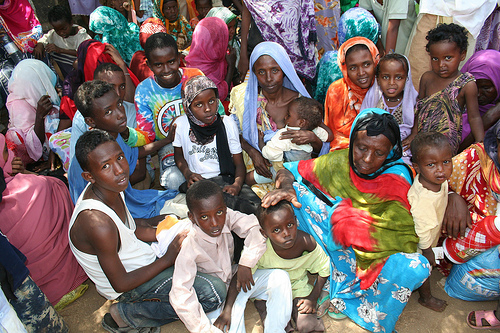

In [145]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.2,0.2,0,0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)


Image.open(test_image)

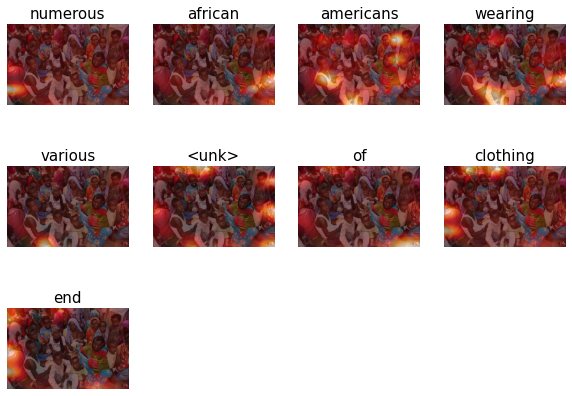

In [146]:
plot_attmap(result, attention_plot, test_image)

**`Analysis Comments`**

- Using the "BLEU score"(Bilingual Evaluation Understudy) as the evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption

- The BLEU Score is almost 70 which is a really nice BLEU Score for few test image, however needs to be improved more.

- The predicted caption is very much simiiar to the actual caption for few images

## Converting the caption to audio using Google Text-to-Speech(gTTS) API

In [99]:
#install gtts
!pip install gTTs

Defaulting to user installation because normal site-packages is not writeable


In [100]:
#install playsound
!pip install playsound
#!pip install pygobject

Defaulting to user installation because normal site-packages is not writeable


In [147]:
from gtts import gTTS
from IPython import display
from IPython.display import Audio 
from playsound import playsound

tts = gTTS(pred_caption, slow = False)
tts.save('dataset/pred_caption1.mp3')

#playsound('dataset/pred_caption1.mp3')

In [148]:
Audio('dataset/pred_caption1.mp3',autoplay=True)

## Result

The "Text To Speech" mp3 file is generated as pred_caption1.mp3

### Beam Search(optional)

In [149]:
captions=beam_evaluate(test_image)
print(captions)

numerous african americans in a of clothing end
